In [27]:
import pandas as pd 
from functions_test_manipulations import get_large_dataset, get_merged_test_and_dict, merge_tests, merge_dictionaries, get_test, get_dictionary
import torch
import functions_ordinal 
import os 
from torch import optim 
import matplotlib.pyplot as plt 
import numpy as np

#  Heldout exam prediction

In [3]:
data, meta_dict = get_large_dataset()

/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_test_manipulations.py:135: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_filepath, index_col=0)


In [6]:
all_test_names = data['TestName'].unique()
print(all_test_names)

['9to1_2017_GCSE_1H' '9to1_2017_GCSE_2H' '9to1_2017_GCSE_3H'
 '9to1_Edexcel_GCSE_Nov2018_1H' '9to1_Edexcel_GCSE_Nov2018_2H'
 '9to1_Edexcel_GCSE_Nov2018_3H' '9to1_Edexcel_Nov2017_GCSE_2H'
 '9to1_Edexcel_Nov2017_GCSE_3H' '9to1_GCSE_Edxcel_Summer2018_1H'
 '9to1_GCSE_Edxcel_Summer2018_2H' '9to1_GCSE_Edxcel_Summer2018_3H'
 '9to1_GCSE_Edxcel_Summer2019_2H' '9to1_GCSE_Edxcel_Summer2019_3H']


In [8]:
# merge tests 1H, 2H and 3H 
test_names = ['9to1_Edexcel_GCSE_Nov2018_1H', '9to1_Edexcel_GCSE_Nov2018_2H',
 '9to1_Edexcel_GCSE_Nov2018_3H']
merged_3_exams, dict_3_exams, IDs  = get_merged_test_and_dict(test_names) # merged_3_exams doesn't have studentID but IDs are studentIDs in the merged exam 
heldout_exam = get_test(data, test_names[-1]) # has student ID and TestName as a column 

/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_test_manipulations.py:98: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_filepath, index_col=0)


In [10]:
# pretrain student parameters on exams 1H and 2H 
questions_heldout_exam = heldout_exam.columns[2:]
test_3H_exam = merged_3_exams[merged_3_exams.columns[-len(questions_heldout_exam):]]
train_1H_2H_exams = merged_3_exams[merged_3_exams.columns[:-len(questions_heldout_exam)]]

In [13]:
print(train_1H_2H_exams) # [13963 rows x 58 columns]

      q1 q2 q3 q4 q5 q6 q7 q8 q9 q10  ... q49 q50 q51 q52 q53 q54 q55 q56 q57  \
0      2  2  2  4  1  1  3  1  3   4  ...   3   2   1   2   2   0   1   5   3   
1      1  2  0  3  2  1  3  1  3   4  ...   3   0   0   1   2   1   0   0   5   
2      1  2  2  5  2  1  0  0  0   4  ...   0   2   1   0   2   0   0   0   3   
3      1  2  2  3  2  1  1  0  0   0  ...   0   0   0   2   2   1   0   0   3   
4      1  2  0  4  2  1  3  1  0   0  ...   0   0   1   2   2   0   0   0   1   
...   .. .. .. .. .. .. .. .. ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
13958  2  2  1  4  2  1  3  0  0   0  ...   3   0   0   2   2   1   1   0   0   
13959  0  1  0  5  0  1  0  0  0   0  ...   0   0   0   1   0   0   0   3   0   
13960  1  0  2  1  2  0  3  0  0   1  ...   3   0   0   1   0   0   0   0   0   
13961  0  1  1  2  0  1  1  0  0   1  ...   1   0   0   0   1   0   0   0   2   
13962  0  1  2  5  2  0  0  0  3   4  ...   0   2   1   1   0   0   0   3   1   

      q58  
0       0  
1  

##  Train student parameters on the 1H and 2H exams 

In [14]:
ordinal_data = train_1H_2H_exams.astype('float')
ordinal_tensor = torch.tensor(ordinal_data.values)

n_students, n_questions = ordinal_tensor.shape[0], ordinal_tensor.shape[1]
max_score = int(ordinal_tensor.max().numpy())

train_data, validation_data, test_data = functions_ordinal.separate_train_validation_test_data(ordinal_tensor)

train_data_max_scores = functions_ordinal.generate_max_scores_tensor(train_data, dict_3_exams)
test_data_max_scores = functions_ordinal.generate_max_scores_tensor(test_data, dict_3_exams)
validation_data_max_scores = functions_ordinal.generate_max_scores_tensor(validation_data, dict_3_exams)
# initialization of parameters 
bs = torch.randn(n_students, requires_grad=True)
bq0 = torch.distributions.uniform.Uniform(0,1).sample([n_questions,])
rho = torch.normal(0, 0.1, size = (n_questions, max_score - 1), requires_grad=True) # rho1, rho2, rho3 

bq0.requires_grad = True  


nlls_train = []
nlls_validation = []
nlls_test = []

iterations = 4000
params = [bs, bq0, rho]

opt = optim.SGD(params, lr = 0.0001)

for iter in range(iterations):
    loss = functions_ordinal.nll(train_data, params, max_score, train_data_max_scores)    
    opt.zero_grad()
    loss.backward()
    opt.step()
    nlls_train.append(loss.detach().numpy())

    loss_validation = functions_ordinal.nll(validation_data, params, max_score, validation_data_max_scores)
    loss_test = functions_ordinal.nll(test_data, params, max_score, test_data_max_scores)

    nlls_validation.append(loss_validation.detach().numpy())
    nlls_test.append(loss_test.detach().numpy())

    if iter % 100 == 0:
        print(iter)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


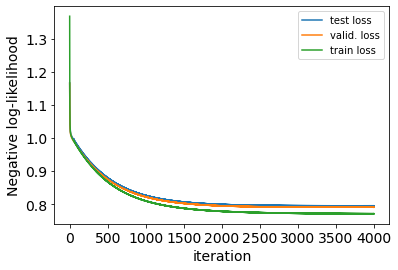

In [15]:
nlls_train_scaled = [x/train_data.shape[0] for x in nlls_train]
nlls_test_scaled = [x/test_data.shape[0] for x in nlls_test]
nlls_validation_scaled = [x/validation_data.shape[0] for x in nlls_validation]

plt.plot(nlls_test_scaled, label = 'test loss')
plt.plot(nlls_validation_scaled, label = 'valid. loss')
plt.plot(nlls_train_scaled, label = 'train loss')
plt.legend()
plt.xlabel('iteration', fontsize = 14)
plt.xticks(fontsize=14)
plt.ylabel('Negative log-likelihood', fontsize = 14)
plt.yticks(fontsize=14)
plt.show()

In [16]:
# select students that are not in the intersection of the exams 1H and 2H
# heldout_exam_train = heldout_exam.loc[~heldout_exam['AnonymousStudentID'].isin(studentID_heldout_exam)]

# select students that are in the intersection of the exams 1H and 2H because they will be used the testing 
# heldout_exam_test = heldout_exam.loc[heldout_exam['AnonymousStudentID'].isin(studentID_heldout_exam)]

##  Train question parameters for the heldout exam 

In [17]:
heldout_exam_train = heldout_exam.loc[~heldout_exam['AnonymousStudentID'].isin(IDs)]
heldout_exam_test = heldout_exam.loc[heldout_exam['AnonymousStudentID'].isin(IDs)]

In [18]:
if 'TestName' in heldout_exam_train.columns:
    heldout_exam_train.drop(columns=['TestName'], inplace = True)
if 'AnonymousStudentID' in heldout_exam_train.columns:
    heldout_exam_train.drop(columns=['AnonymousStudentID'], inplace = True)

/var/folders/1r/b1xnxlh94bj9wjtrptr85kf80000gn/T/ipykernel_92905/346631093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heldout_exam_train.drop(columns=['TestName'], inplace = True)
/var/folders/1r/b1xnxlh94bj9wjtrptr85kf80000gn/T/ipykernel_92905/346631093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heldout_exam_train.drop(columns=['AnonymousStudentID'], inplace = True)


In [19]:
print(heldout_exam_test.shape)
print(heldout_exam_train.shape)
print(heldout_exam.shape)

(13963, 32)
(6148, 30)
(20111, 32)


##  Train on the heldout exam to gauge question difficulty

In [20]:
heldout_ordinal_train = heldout_exam_train.astype('float')
heldout_tensor = torch.tensor(heldout_ordinal_train.values)

n_students, n_questions = heldout_tensor.shape[0], heldout_tensor.shape[1]
max_score = int(heldout_tensor.max().numpy())

def dataframe_to_triplets(ordinal_data):
    """
    Converts dataframe (rows are questions; columns are students) to triplets in the form 
    [studentID, questionID, score] for each student-question pair 
    """
    n_students, n_questions = ordinal_data.shape[0], ordinal_data.shape[1]

    ordinal_data = ordinal_data.reshape(-1)

    student_id = torch.arange(1, n_students + 1)
    student_id = student_id.repeat_interleave(n_questions)

    question_id = torch.arange(1, n_questions + 1)
    question_id = question_id.repeat(n_students)

    data = torch.stack((student_id, question_id, ordinal_data), dim=1)
    return data 

heldout_triplets = dataframe_to_triplets(heldout_tensor)

In [21]:
heldout_dict = get_dictionary(meta_dict, test_names[-1])

In [22]:
max_scores = functions_ordinal.generate_max_scores_tensor(heldout_triplets, heldout_dict)

# initialization of parameters 
bs_heldout = torch.randn(n_students, requires_grad=True)
bq0_heldout = torch.distributions.uniform.Uniform(0,1).sample([n_questions,])
rho_heldout = torch.normal(0, 0.1, size = (n_questions, max_score - 1), requires_grad=True) # rho1, rho2, rho3 

bq0_heldout.requires_grad = True  


nlls_train_heldout  = []

iterations = 4000
params = [bs_heldout, bq0_heldout, rho_heldout]

opt = optim.SGD(params, lr = 0.0001)

for iter in range(iterations):
    loss = functions_ordinal.nll(heldout_triplets, params, max_score, max_scores)    
    opt.zero_grad()
    loss.backward()
    opt.step()
    nlls_train_heldout.append(loss.detach().numpy())

    if iter % 100 == 0:
        print(iter)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


##  Prediction on heldout exam

In [23]:
if 'TestName' in heldout_exam_test.columns:
    heldout_exam_test.drop(columns=['TestName'], inplace = True)
if 'AnonymousStudentID' in heldout_exam_test.columns:
    heldout_exam_test.drop(columns=['AnonymousStudentID'], inplace = True)

heldout_exam_test = heldout_exam_test.astype('float')
heldout_exam_test_tensor = torch.tensor(heldout_exam_test.values)
test_data_heldout_exam = dataframe_to_triplets(heldout_exam_test_tensor)

/var/folders/1r/b1xnxlh94bj9wjtrptr85kf80000gn/T/ipykernel_92905/2433522683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heldout_exam_test.drop(columns=['TestName'], inplace = True)
/var/folders/1r/b1xnxlh94bj9wjtrptr85kf80000gn/T/ipykernel_92905/2433522683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heldout_exam_test.drop(columns=['AnonymousStudentID'], inplace = True)


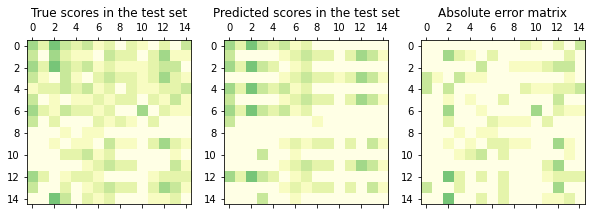

Accuracy on the test data after training is 0.6854305


In [24]:

# TEST GRID PREDICTIONS 
# Get accuracies and predictions on the test data 
test_data_max_scores = functions_ordinal.generate_max_scores_tensor(test_data_heldout_exam, heldout_dict)
prob_matrix = functions_ordinal.generate_prob_matrix(test_data_heldout_exam, bs, bq0_heldout, rho_heldout, max_score, test_data_max_scores)


predicted_scores_thresholding = prob_matrix.argmax(axis = 1)
predicted_scores = predicted_scores_thresholding


true_scores = test_data_heldout_exam[:, 2]

dim = 15 
pred_mat = predicted_scores[10000:10000+dim*dim].reshape((dim,dim))
true_mat = true_scores[10000:10000+dim*dim].reshape((dim,dim))

_min, _max = 0, max_score
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(10)

ax[0].matshow(true_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
ax[0].set_title('True scores in the test set')


ax[1].matshow(pred_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
ax[1].set_title('Predicted scores in the test set')



diff_mat = torch.abs(pred_mat - true_mat)
ax[2].matshow(diff_mat.detach().numpy(),cmap=plt.cm.YlGn,vmin = _min, vmax = _max)
ax[2].set_title('Absolute error matrix')

save_fig_location = os.path.join(os.getcwd(), 'figures', 'test_grid__2T_Summer2019.png')
plt.savefig(save_fig_location)
plt.show()

print('Accuracy on the test data after training is', functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy())


### Overall prediction on the heldout exam 


In [30]:
print(test_data_heldout_exam.shape)
print(test_data_heldout_exam_max_scores.shape)
print(bs_heldout.shape)
print(bq0_heldout.shape)

torch.Size([418890, 3])
torch.Size([418890])
torch.Size([6148])
torch.Size([30])


In [28]:
test_data_heldout_exam_max_scores = functions_ordinal.generate_max_scores_tensor(test_data_heldout_exam, heldout_dict)

prob_matrix = functions_ordinal.generate_prob_matrix(test_data_heldout_exam, bs_heldout, bq0_heldout, rho_heldout, max_score, test_data_heldout_exam_max_scores)
predicted_scores = prob_matrix.argmax(axis = 1)
true_scores = test_data_heldout_exam[:, 2]
scores_matrix = torch.tensor(list(np.arange(0, max_score + 1, 1))).repeat(prob_matrix.shape[0], 1)
expected_value_matrix = torch.mul(prob_matrix, scores_matrix) 
predicted_expected_value_scores = expected_value_matrix.sum(axis = 1)

IndexError: index out of range in self